# Virus Transmission

Virus spread can not only cause serious health issues, but also overload health systems.

In this project we will take a look at a virus transmission in a population.

Our goal is to look for insights that can help us to take better actions to prevent the fast spread of the virus.

In the end of every section I'll point out some insights that are relevant for the rest of the project.

<center><img src="images/virus-transmission.jpg"/></center>

## Content Table

- [1 Script Configurations](#1-Script-Configurations)
- [2 Exploring the Datasets](#2-Exploring-the-Datasets)
    - [2.1 Population](#2.1-Population)
    - [2.2 Connections](#2.2-Connections)
- [3 Data Manipulation](#3-Data-Manipulation)
- [4 Predictive Modeling](#4-Predictive-Modeling)
    - [4.1 Preprocessing](#4.1-Preprocessing)
    - [4.2 Evaluation Metrics](#4.2-Evaluation-Metrics)
    - [4.3 Minimum Samples](#4.3-Minimum-Samples)
    - [4.4 Colinearity](#4.4-Colinearity)
    - [4.5 Results](#4.5-Results)
- [5 Taking Actions](#5-Taking-Actions)
    - [5.1 Feature's Impact](#5.1-Feature's-Impact)
    - [5.2 Running Simulations](#5.2-Running-Simulations)
- [6 Conclusions](#6-Conclusions)

## 1 Script Configurations

In this first section, we are going to import the Python modules used throughout this project, as well as define some global configurations.

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import shapiro, ttest_ind
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Configurations
np.random.seed(1)
warnings.filterwarnings('ignore')

In [3]:
# Global variables
CV = 3
DATASETS_PATH = 'datasets'

## 2 Exploring the Datasets

Before jumping into machine learning, let's have a look at the data and see what insights we can obtain.

### 2.1 Population

The first dataset is a list of people and its characteristics.

In [4]:
# Load the dataset
population = pd.read_excel(f'{DATASETS_PATH}/individuos_espec.xlsx')

# Translate columns to english
population = population.rename(columns={
    'name': 'name',
    'idade': 'age',
    'estado_civil': 'marital_status',
    'qt_filhos': 'n_children',
    'estuda': 'study',
    'trabalha': 'work',
    'pratica_esportes': 'play_sports',
    'transporte_mais_utilizado': 'transportation',
    'IMC': 'body_mass_index'
})

# Translate values to english
population = population.replace({
    'divorciado': 'divorced',
    'casado': 'married',
    'solteiro': 'single',
    'viuvo': 'widow',
    'publico': 'public',
    'particular': 'private',
    'taxi': 'taxi',
})

population.head()

,name,age,marital_status,n_children,study,work,play_sports,transportation,body_mass_index
0,1,44.0,divorced,1.0,1.0,0.0,1.0,public,2.220096e+14
1,2,24.0,married,0.0,0.0,0.0,1.0,public,2.537872e+14
2,3,35.0,single,1.0,0.0,0.0,1.0,private,1.995239e+14
3,4,50.0,married,1.0,1.0,1.0,0.0,public,2.673205e+14
4,5,30.0,single,2.0,1.0,0.0,1.0,public,1.529567e+14


In [5]:
# Dataset shape
print(f'dataset shape: {population.shape}')

dataset shape: (1000000, 9)


In [6]:
# Features and types
population.dtypes

name                 int64
age                float64
marital_status      object
n_children         float64
study              float64
work               float64
play_sports        float64
transportation      object
body_mass_index    float64
dtype: object

In [7]:
# Check for missing or null values in order_products
print(f'number of missing values: {population.isna().sum().sum()}')

number of missing values: 527387


In [8]:
# Locating the missing values
population.isna().sum()

name                    0
age                 95937
marital_status      50073
n_children          28867
study               40130
work                 6353
play_sports        149124
transportation      43033
body_mass_index    113870
dtype: int64

In [9]:
# Dataset statistics
population.describe()

,name,age,n_children,study,work,play_sports,body_mass_index
count,1000000.000000,904063.000000,971133.000000,959870.000000,993647.000000,850876.000000,8.861300e+05
mean,500000.500000,30.008431,0.928406,0.442588,0.556739,0.599823,2.089921e+14
std,288675.278932,10.951566,0.997289,0.496693,0.496771,0.489934,1.051577e+14
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.371942e+09
25%,250000.750000,22.000000,0.000000,0.000000,0.000000,0.000000,1.604842e+14
50%,500000.500000,29.000000,1.000000,0.000000,1.000000,1.000000,2.063203e+14
75%,750000.250000,37.000000,1.000000,1.000000,1.000000,1.000000,2.584227e+14
max,1000000.000000,124.000000,9.000000,1.000000,1.000000,1.000000,9.999966e+14


In [10]:
# Number of unique values
population.nunique()

name               1000000
age                    105
marital_status           4
n_children              10
study                    2
work                     2
play_sports              2
transportation           3
body_mass_index     886130
dtype: int64

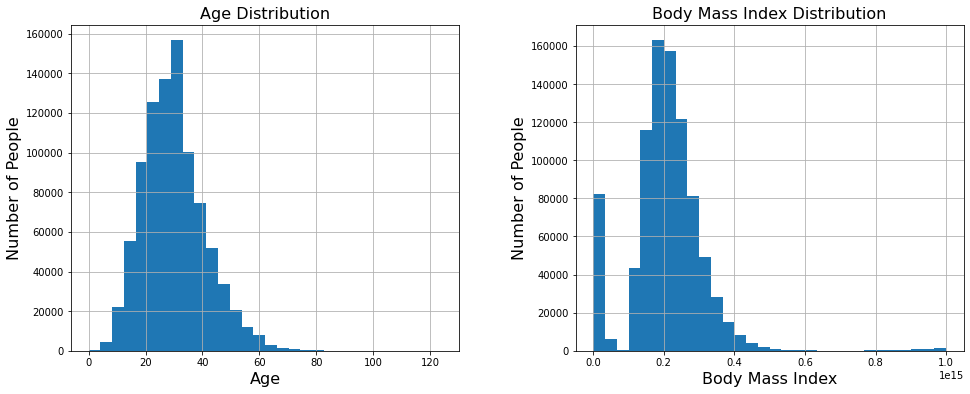

In [11]:
# Numerical distributions
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

population.hist('age', bins=30, ax=ax[0])
ax[0].set_xlabel('Age', size=16)
ax[0].set_ylabel('Number of People', size=16)
ax[0].set_title('Age Distribution', size=16)

population.hist('body_mass_index', bins=30, ax=ax[1])
ax[1].set_xlabel('Body Mass Index', size=16)
ax[1].set_ylabel('Number of People', size=16)
ax[1].set_title('Body Mass Index Distribution', size=16)

plt.show()

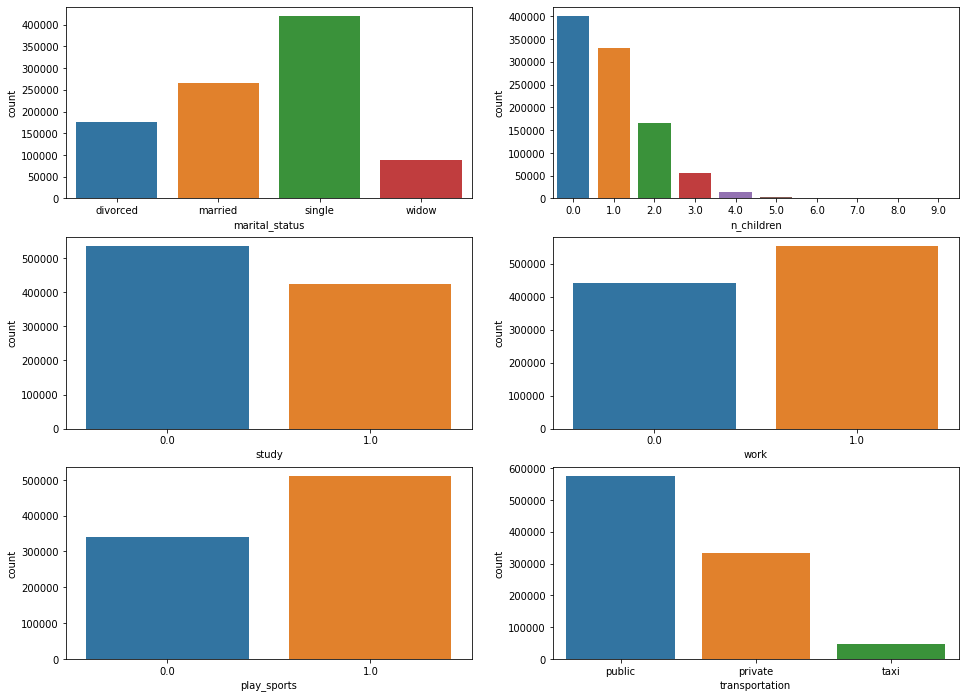

In [12]:
# Categorical distributions
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

sns.countplot(x='marital_status', data=population, ax=ax[0, 0])
sns.countplot(x='n_children', data=population, ax=ax[0, 1])
sns.countplot(x='study', data=population, ax=ax[1, 0])
sns.countplot(x='work', data=population, ax=ax[1, 1])
sns.countplot(x='play_sports', data=population, ax=ax[2, 0])
sns.countplot(x='transportation', data=population, ax=ax[2, 1])

plt.show()

**Observations:**
- *name* is the ID of the person - only useful to merge datasets and can be dropped
- there's a lot of people in this dataset, let's see how many of them are actualy used in the next dataset
- there's a lot of missing value as well (let's see if we drop or replace them)
- *marital_status* and *transportation* are categorical feature that need to be converted
- there are some outliers in *age*, *n_children* and *body_mass_index* (we can drop them or use a more rubust model)
- most of the people use public transportation, while just a few use taxi

## 2.2 Connections

Next we have a dataset containing a list of people connections and its virus transmission rate.

In [13]:
# Load the dataset
connections = pd.read_excel(f'{DATASETS_PATH}/conexoes_espec.xlsx')

# Translate columns to english
connections = connections.rename(columns={
    'V1': 'infecting',
    'V2': 'infected',
    'grau': 'degree',
    'proximidade': 'proximity',
    'prob_V1_V2': 'transmission_rate'
})

# Translate values to english
connections = connections.replace({
    'trabalho': 'work',
    'amigos': 'friends',
    'familia': 'family',
    'visita_frequente': 'frequent_visit',
    'visita_rara': 'rare_visit',
    'visita_casual': 'casual_visit',
    'mora_junto': 'live_together',
})

connections.head()

,infecting,infected,degree,proximity,transmission_rate
0,1,2,work,frequent_visit,0.589462
1,1,3,work,rare_visit,0.708465
2,2,4,work,casual_visit,NaN
3,2,5,work,rare_visit,0.638842
4,3,6,friends,live_together,NaN


In [14]:
# Dataset shape
print(f'dataset shape: {connections.shape}')

dataset shape: (999999, 5)


In [15]:
# Features and types
connections.dtypes

infecting              int64
infected               int64
degree                object
proximity             object
transmission_rate    float64
dtype: object

In [16]:
# Check for missing or null values in order_products
print(f'number of missing values: {connections.isna().sum().sum()}')

number of missing values: 500000


In [17]:
# Locating the missing values
connections.isna().sum()

infecting                 0
infected                  0
degree                    0
proximity                 0
transmission_rate    500000
dtype: int64

In [18]:
# Dataset statistics
connections.describe()

,infecting,infected,transmission_rate
count,999999.000000,999999.000000,499999.000000
mean,250000.250000,500001.000000,0.485162
std,144337.495129,288674.990257,0.173963
min,1.000000,2.000000,0.074462
25%,125000.500000,250001.500000,0.351677
50%,250000.000000,500001.000000,0.486413
75%,375000.000000,750000.500000,0.618210
max,500000.000000,1000000.000000,0.942245


In [19]:
# Number of unique values
connections.nunique()

infecting            500000
infected             999999
degree                    3
proximity                 4
transmission_rate    499999
dtype: int64

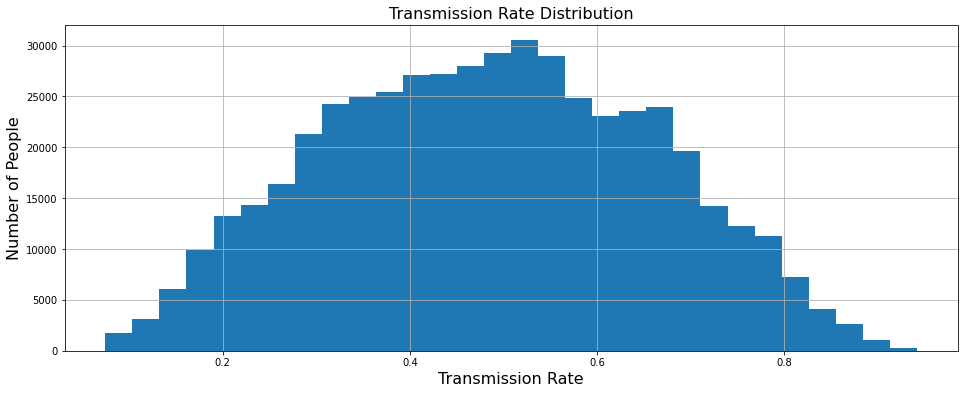

In [20]:
# Numerical distributions
_, ax = plt.subplots(figsize=(16, 6))
connections.hist('transmission_rate', bins=30, ax=ax)
ax.set_xlabel('Transmission Rate', size=16)
ax.set_ylabel('Number of People', size=16)
ax.set_title('Transmission Rate Distribution', size=16)
plt.show()

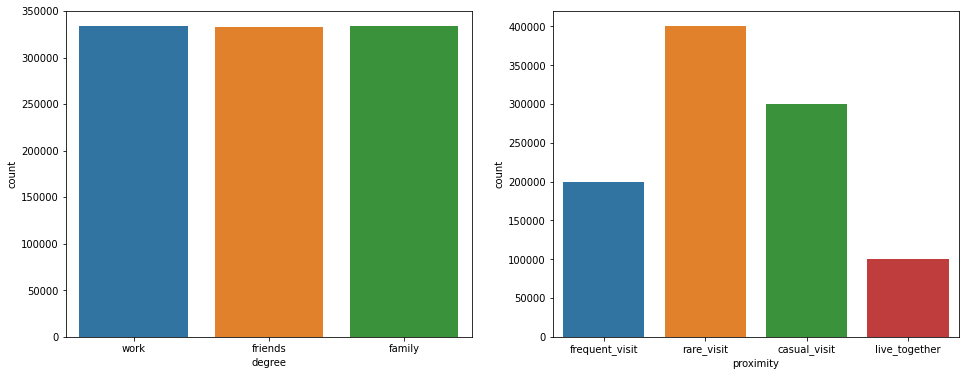

In [21]:
# Categorical distributions
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='degree', data=connections, ax=ax[0])
sns.countplot(x='proximity', data=connections, ax=ax[1])
plt.show()

**Observations:**
- *infecting* and *infected* will only be used to merge datasets
- here we have another dataset with lot of samples and we'll probably use just a subsample of it to evaluate the machine learning models
- half of the dataset does not contain the target variable *transmission_rate* and will be put aside as the submission file
- most of the people make *rare_visits*, while few people *live_together*

## 3 Data Manipulation

After having a quick look at the data, now it's time to prepare a dataset to be modeled.

In [22]:
# Merge datasets
dataframe = pd.merge(connections, population, left_on='infecting', right_on='name')
dataframe = pd.merge(dataframe, population, left_on='infected', right_on='name', suffixes=['_infecting', '_infected'])
dataframe.head()

,infecting,infected,degree,proximity,transmission_rate,name_infecting,age_infecting,marital_status_infecting,n_children_infecting,study_infecting,...,body_mass_index_infecting,name_infected,age_infected,marital_status_infected,n_children_infected,study_infected,work_infected,play_sports_infected,transportation_infected,body_mass_index_infected
0,1,2,work,frequent_visit,0.589462,1,44.0,divorced,1.0,1.0,...,2.220096e+14,2,24.0,married,0.0,0.0,0.0,1.0,public,2.537872e+14
1,1,3,work,rare_visit,0.708465,1,44.0,divorced,1.0,1.0,...,2.220096e+14,3,35.0,single,1.0,0.0,0.0,1.0,private,1.995239e+14
2,2,4,work,casual_visit,NaN,2,24.0,married,0.0,0.0,...,2.537872e+14,4,50.0,married,1.0,1.0,1.0,0.0,public,2.673205e+14
3,2,5,work,rare_visit,0.638842,2,24.0,married,0.0,0.0,...,2.537872e+14,5,30.0,single,2.0,1.0,0.0,1.0,public,1.529567e+14
4,3,6,friends,live_together,NaN,3,35.0,single,1.0,0.0,...,1.995239e+14,6,20.0,NaN,1.0,0.0,1.0,0.0,public,2.041294e+14


In [23]:
# Drop IDs
dataframe_dropped = dataframe.drop(['infecting', 'infected', 'name_infecting', 'name_infected'], axis=1)
dataframe_dropped.head()

,degree,proximity,transmission_rate,age_infecting,marital_status_infecting,n_children_infecting,study_infecting,work_infecting,play_sports_infecting,transportation_infecting,body_mass_index_infecting,age_infected,marital_status_infected,n_children_infected,study_infected,work_infected,play_sports_infected,transportation_infected,body_mass_index_infected
0,work,frequent_visit,0.589462,44.0,divorced,1.0,1.0,0.0,1.0,public,2.220096e+14,24.0,married,0.0,0.0,0.0,1.0,public,2.537872e+14
1,work,rare_visit,0.708465,44.0,divorced,1.0,1.0,0.0,1.0,public,2.220096e+14,35.0,single,1.0,0.0,0.0,1.0,private,1.995239e+14
2,work,casual_visit,NaN,24.0,married,0.0,0.0,0.0,1.0,public,2.537872e+14,50.0,married,1.0,1.0,1.0,0.0,public,2.673205e+14
3,work,rare_visit,0.638842,24.0,married,0.0,0.0,0.0,1.0,public,2.537872e+14,30.0,single,2.0,1.0,0.0,1.0,public,1.529567e+14
4,friends,live_together,NaN,35.0,single,1.0,0.0,0.0,1.0,private,1.995239e+14,20.0,NaN,1.0,0.0,1.0,0.0,public,2.041294e+14


In [24]:
# Replace NaN values on the submission samples
dataframe_replaced = dataframe_dropped.copy()

MODE_FEATURES = [
    'degree',
    'proximity',
    'n_children_infecting',
    'study_infecting',
    'work_infecting',
    'play_sports_infecting',
    'marital_status_infecting',
    'transportation_infecting',
    'n_children_infected',
    'study_infected',
    'work_infected',
    'play_sports_infected',
    'marital_status_infected',
    'transportation_infected'
]
MEAN_FEATURES = [
    'age_infecting',
    'body_mass_index_infecting',
    'age_infected',
    'body_mass_index_infected',
]

modes = dataframe_replaced[MODE_FEATURES].mode()
means = dataframe_replaced[MEAN_FEATURES].mean(axis=0)

dataframe_replaced = dataframe_replaced.fillna(modes.iloc[0])
dataframe_replaced = dataframe_replaced.fillna(means)

dataframe_replaced.isna().sum()

degree                            0
proximity                         0
transmission_rate            500000
age_infecting                     0
marital_status_infecting          0
n_children_infecting              0
study_infecting                   0
work_infecting                    0
play_sports_infecting             0
transportation_infecting          0
body_mass_index_infecting         0
age_infected                      0
marital_status_infected           0
n_children_infected               0
study_infected                    0
work_infected                     0
play_sports_infected              0
transportation_infected           0
body_mass_index_infected          0
dtype: int64

In [25]:
# Categorical to numerical features
dataframe_numerical = dataframe_replaced.copy()

dataframe_numerical['proximity'] = dataframe_numerical['proximity'].replace({
    'rare_visit': 0,
    'casual_visit': 1,
    'frequent_visit': 2,
    'live_together': 3
})

for feature in ['degree', 'marital_status_infecting', 'transportation_infecting', 'marital_status_infected', 'transportation_infected']:
    column = dataframe_numerical.pop(feature)
    new_columns = pd.get_dummies(column, prefix=feature)
    dataframe_numerical = pd.concat([dataframe_numerical, new_columns], axis=1)

dataframe_numerical.head()

,proximity,transmission_rate,age_infecting,n_children_infecting,study_infecting,work_infecting,play_sports_infecting,body_mass_index_infecting,age_infected,n_children_infected,...,transportation_infecting_private,transportation_infecting_public,transportation_infecting_taxi,marital_status_infected_divorced,marital_status_infected_married,marital_status_infected_single,marital_status_infected_widow,transportation_infected_private,transportation_infected_public,transportation_infected_taxi
0,2,0.589462,44.0,1.0,1.0,0.0,1.0,2.220096e+14,24.0,0.0,...,0,1,0,0,1,0,0,0,1,0
1,0,0.708465,44.0,1.0,1.0,0.0,1.0,2.220096e+14,35.0,1.0,...,0,1,0,0,0,1,0,1,0,0
2,1,NaN,24.0,0.0,0.0,0.0,1.0,2.537872e+14,50.0,1.0,...,0,1,0,0,1,0,0,0,1,0
3,0,0.638842,24.0,0.0,0.0,0.0,1.0,2.537872e+14,30.0,2.0,...,0,1,0,0,0,1,0,0,1,0
4,3,NaN,35.0,1.0,0.0,0.0,1.0,1.995239e+14,20.0,1.0,...,1,0,0,0,0,1,0,0,1,0


In [26]:
# Set aside the submission dataframe

# DISCLAIMER: I'll be dropping the training samples that had 
# missing values because I believe there's enough complete samples
# to train a fairly good model.

dataframe_modeling = dataframe_numerical[
    (~dataframe_numerical['transmission_rate'].isna()) &
    (dataframe_dropped.isna().sum(axis=1) == 0)
]
dataframe_submission = dataframe_numerical[dataframe_numerical['transmission_rate'].isna()]
print(f'modeling shape: {dataframe_modeling.shape}')
print(f'submission shape: {dataframe_submission.shape}')

modeling shape: (164467, 31)
submission shape: (500000, 31)


**Observations:**
- datasets merged
- missing values samples dropped, except for the submission samples
- missing values of the submission samples filled with mean and mode values
- categorical features replaced by new numerical features

## 4 Predictive Modeling

In this section we are going to model the data to estimate the transmission rate between people.

### 4.1 Preprocessing

First we have to split and scale the dataset.

In [27]:
# Split dataset
x = dataframe_modeling.drop('transmission_rate', axis=1)
y = dataframe_modeling['transmission_rate']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print(f'train size: {len(x_train)}')
print(f'test size: {len(x_test)}')

train size: 115126
test size: 49341


In [28]:
# Scale dataset
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)
y_train = y_train.values
y_test = y_test.values

In [29]:
# Significance level between train and test
_, p_value = ttest_ind(x_train_norm, x_test_norm)
for i, feature in enumerate(x):
    print(f'{feature}: {p_value[i]}')

proximity: 0.2539280339360247
age_infecting: 0.6145773264994396
n_children_infecting: 0.817528070564721
study_infecting: 0.14998200357247718
work_infecting: 0.5591264201294
play_sports_infecting: 0.9609362969119717
body_mass_index_infecting: 0.4690865786073415
age_infected: 0.27523756580901465
n_children_infected: 0.6969521577269875
study_infected: 0.6751345193886885
work_infected: 0.24781627154206454
play_sports_infected: 0.45367883540939746
body_mass_index_infected: 0.5924475761910879
degree_family: 0.28179726545092926
degree_friends: 0.12451496212940016
degree_work: 0.647537493413505
marital_status_infecting_divorced: 0.6630865120902036
marital_status_infecting_married: 0.4381737011058795
marital_status_infecting_single: 0.20330891807271767
marital_status_infecting_widow: 0.1162351221921734
transportation_infecting_private: 0.8199328003480868
transportation_infecting_public: 0.6200564634470893
transportation_infecting_taxi: 0.5363264685878375
marital_status_infected_divorced: 0.4858

In [30]:
# Preprocess submission samples
x_submission = dataframe_submission.drop('transmission_rate', axis=1)
y_submission = dataframe_submission['transmission_rate']

x_submission_norm = scaler.transform(x_submission)
y_submission = y_submission.values

**Observations:**
- the significance level between the train and test tells us that the distribution is similar

### 4.2 Evaluation Metrics

Here we define the evaluation functions used to compare the models that we are going to create.
- **business function:** this business function generates larger errors when the estimation rate is higher than the actual rate
- **mean absolute error:** was chosen due to the ability to easly understand the error (in this case transmission rate)
- **cross validation:** provides information about how well a classifier generalizes by rotating the train and test samples
- **random forest:** is a robust combination of decision trees (tree-like models)

In [31]:
# Business scoring
def business_function(y, y_hat):
    y = y.reshape(1, -1)
    y_hat = y_hat.reshape(1, -1)
    mse = mean_absolute_error(y, y_hat, multioutput="raw_values")

    errors = (y - y_hat).reshape(-1, 1)
    mse = np.where(errors[:, 0] >= 0, mse * 0.5, mse)
    mse = np.where(errors[:, 0] < 0, mse * 2, mse)

    return mse.mean()

business_scoring = make_scorer(business_function, greater_is_better=False)

In [32]:
# Train function
def train(x, y):

    model = RandomForestRegressor(
        n_estimators=50,
        criterion='mae',
        oob_score=True,
        random_state=1
    )
    
    cv_scores = cross_validate(
        model,
        x,
        y,
        scoring=business_scoring,
        cv=CV,
        return_train_score=True
    )

    model.fit(x, y)

    results = {
        'train_score_mean': -1 * cv_scores['train_score'].mean(),
        'train_score_std': -1 * cv_scores['train_score'].std(),
        'validation_score_mean': -1 * cv_scores['test_score'].mean(),
        'validation_score_std': -1 * cv_scores['test_score'].std(),
        'model': model
    }

    return results

In [33]:
# Predict function
def predict(x, model):
    y_hat = model.predict(x)
    return y_hat

In [34]:
# Evaluation function
def evaluate(y, y_hat):

    # compute mse
    score = business_function(y, y_hat)

    # statistical test
    y = y.reshape(1, -1)
    y_hat = y_hat.reshape(1, -1)
    errors = (y - y_hat).reshape(-1, 1)
    errors_norm = StandardScaler().fit_transform(errors)
    _, p_value = shapiro(errors_norm)
    
    # plot
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

    ax[0].scatter(y[0, :], errors)
    ax[0].set_xlabel('Expected Value', size=16)
    ax[0].set_ylabel('Absolute Error', size=16)
    ax[0].set_title(f'MAE = {score}', size=16)
    ax[0].grid()

    ax[1].hist(errors[:, 0], bins=100)
    ax[1].set_xlabel('Error', size=16)
    ax[1].set_ylabel('Count', size=16)
    ax[1].set_title(f'p-value = {p_value}', size=16)

### 4.3 Minimum Samples

Let's see if we can use only a subsample of our dataset to speed up the modeling.

In [35]:
%%time

# Compute learning curves
train_sizes, train_errors, validation_errors, fit_times, _ = learning_curve(
    RandomForestRegressor(n_estimators=50, criterion='mae', oob_score=True, random_state=1),
    x_train_norm,
    y_train,
    cv=CV,
    train_sizes=[0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15],
    scoring=business_scoring,
    return_times=True
)

CPU times: user 38min 45s, sys: 6.65 s, total: 38min 52s
Wall time: 39min 12s


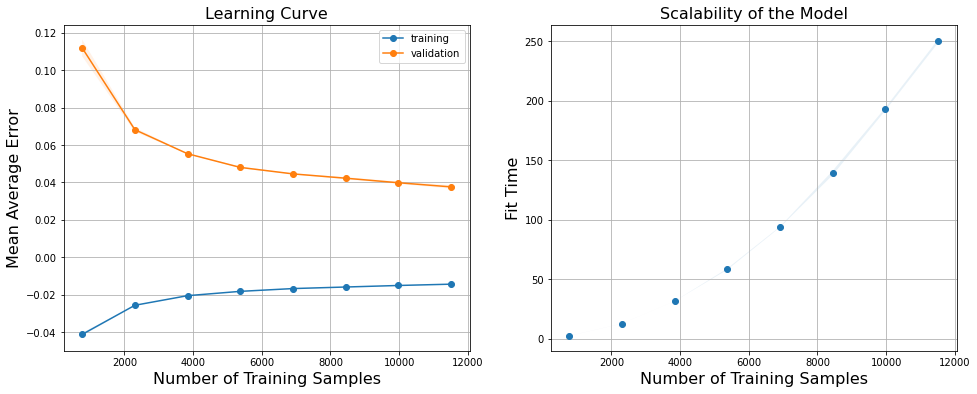

In [36]:
# Plot learning curves

train_errors_mean = train_errors.mean(axis=1)
validation_errors_mean = -1 * validation_errors.mean(axis=1)
fit_times_mean = fit_times.mean(axis=1)

train_errors_std = train_errors.std(axis=1)
validation_errors_std = -1 * validation_errors.std(axis=1)
fit_times_std = fit_times.std(axis=1)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax[0].fill_between(
    train_sizes,
    train_errors_mean - train_errors_std,
    train_errors_mean + train_errors_std,
    alpha=0.1,
)
ax[0].plot(train_sizes, train_errors_mean, marker='o', label='training')
ax[0].fill_between(
    train_sizes,
    validation_errors_mean - validation_errors_std,
    validation_errors_mean + validation_errors_std,
    alpha=0.1
)
ax[0].plot(train_sizes, validation_errors_mean, marker='o', label='validation')
ax[0].set_title('Learning Curve', size=16)
ax[0].set_ylabel('Mean Average Error', size=16)
ax[0].set_xlabel('Number of Training Samples', size=16)
ax[0].legend(loc='best')
ax[0].grid(True)

ax[1].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.1
)
ax[1].plot(train_sizes, fit_times_mean, 'o')
ax[1].set_title('Scalability of the Model', size=16)
ax[1].set_ylabel('Fit Time', size=16)
ax[1].set_xlabel('Number of Training Samples', size=16)
ax[1].grid(True)

plt.show()

**Observations:**
- since the errors didn't get to a stabe value, I can't specify a minimum training size
- I will skip the hyperparameter tuning for computational reasons, since I will be using more samples than I expected

### 4.4 Colinearity

Since we want to be able to interpret the model (the importance of each feature) it's important to remove high correlated features, otherwise the model can become unstable.

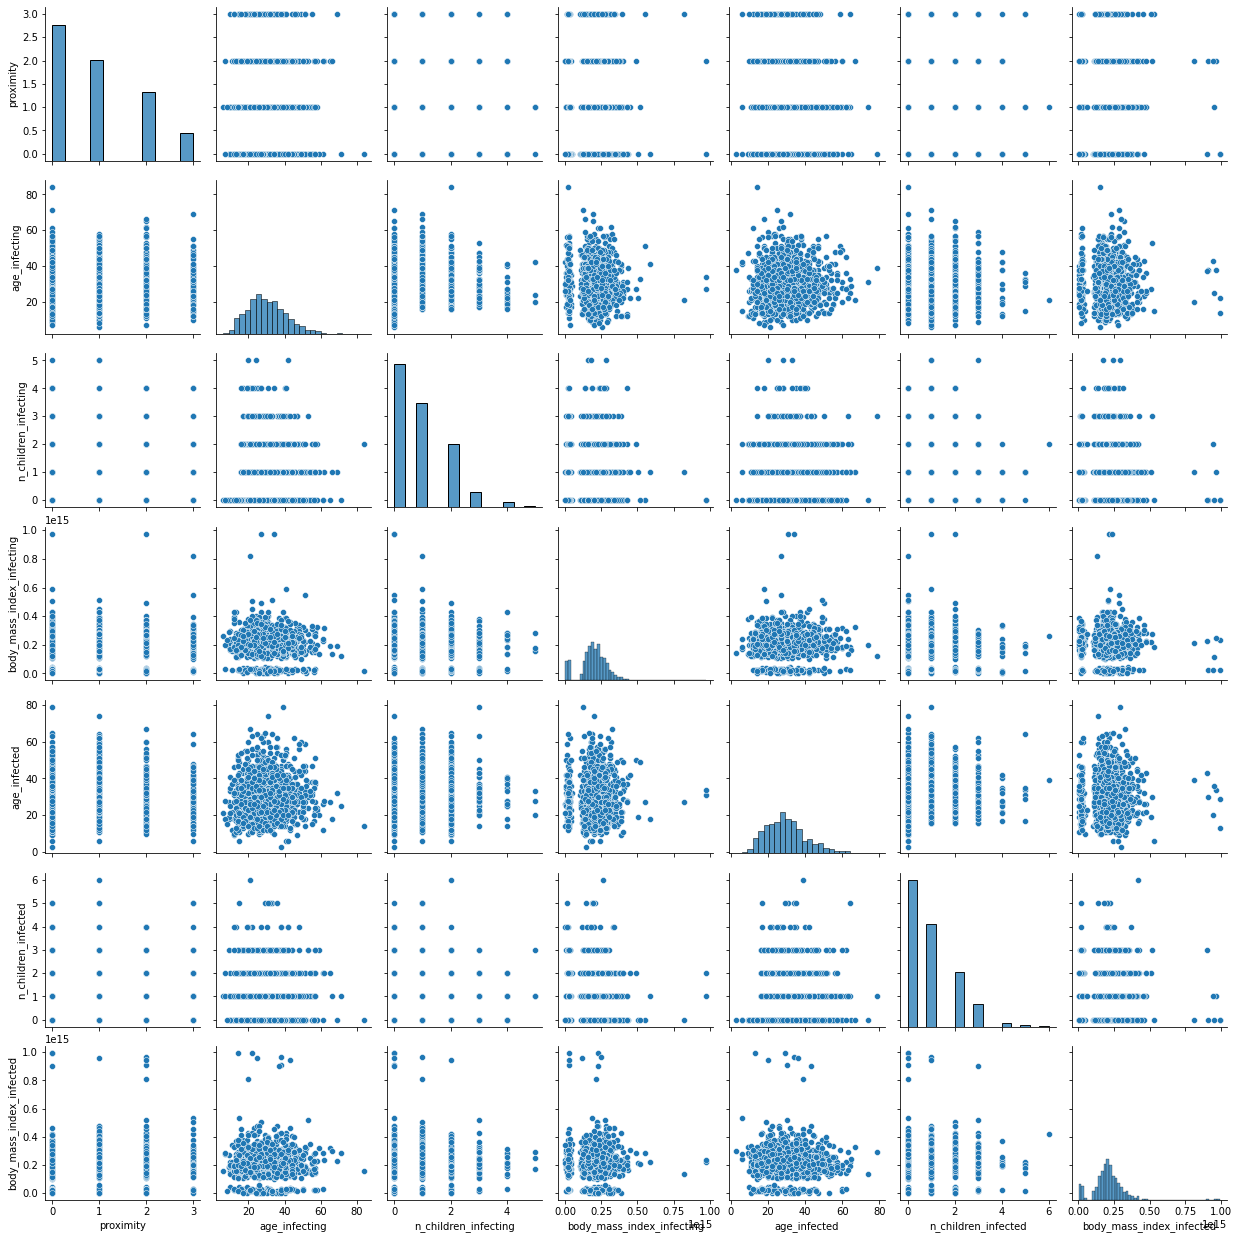

In [37]:
# Plot relationships
FEATURES = [
    'proximity',
    'age_infecting',
    'n_children_infecting',
    'body_mass_index_infecting',
    'age_infected',
    'n_children_infected',
    'body_mass_index_infected'
]
sns.pairplot(x_train[FEATURES].iloc[0:1000])

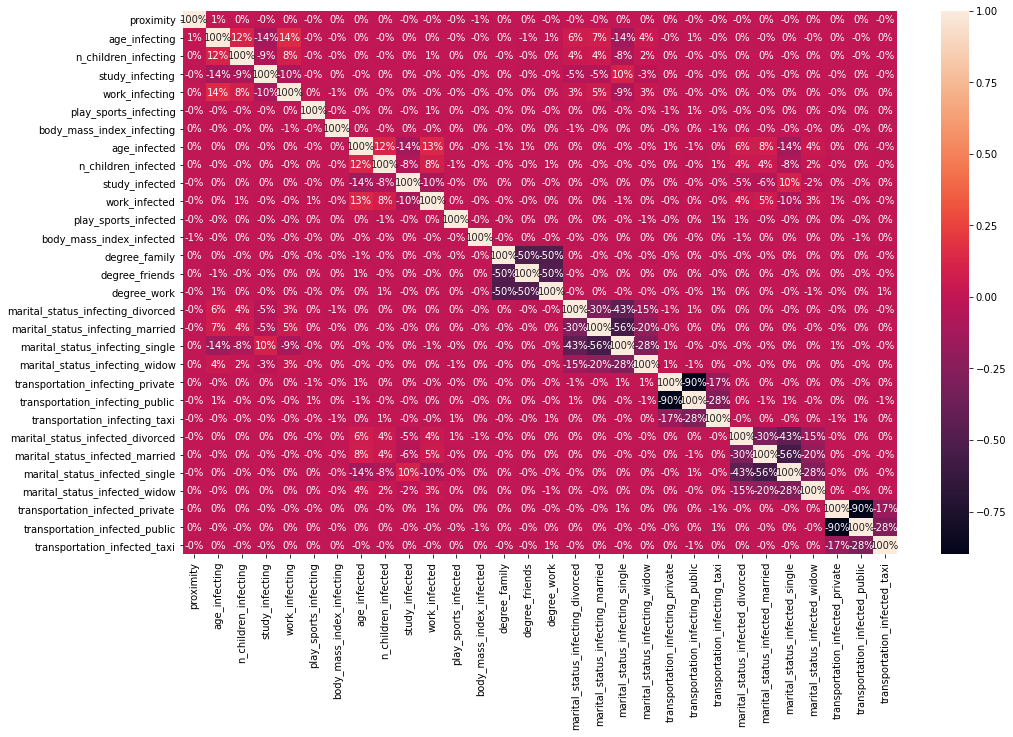

In [38]:
# Pearson's correlation
plt.figure(figsize=(16, 10))
_ = sns.heatmap(x_train.corr(), annot=True, fmt=".0%")

**Observations:**
- I don't see much to be done here, since there's no high correlations

### 4.5 Results

Now let's train the model and evaluate the results.

In [39]:
# Select a part of the dataset

# DISCLAIMER: I will be using a subsample of the train dataset for computational reasons.
# I also estimate that 20% of the train samples the train process wil take about 30 minutes.

train_size = int(len(x_train_norm) * 0.2)
x_train_norm_subsample = x_train_norm[:train_size, :]
y_train_subsample = y_train[:train_size]
print(f'subsample size: {len(x_train_norm_subsample)}')

subsample size: 23025


In [40]:
%%time

# Train
results = train(x_train_norm_subsample, y_train_subsample)
print(f'train score mean: {results["train_score_mean"]}')
print(f'train score std: {results["train_score_std"]}')
print(f'validation score mean: {results["validation_score_mean"]}')
print(f'validation score std: {results["validation_score_std"]}')
print('')

train score mean: 0.013447445258122507
train score std: -4.578940860494579e-05
validation score mean: 0.03546529286326075
validation score std: -0.0005027859481525031

CPU times: user 38min 51s, sys: 4.25 s, total: 38min 56s
Wall time: 39min 10s


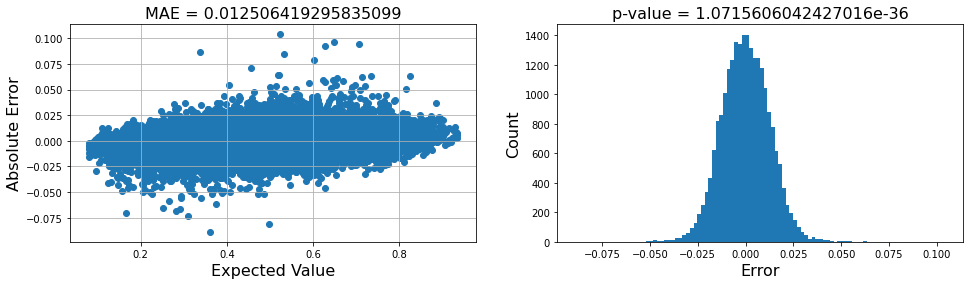

In [41]:
# Evaluate
y_hat = predict(x_train_norm_subsample, results['model'])
evaluate(y_train_subsample, y_hat)

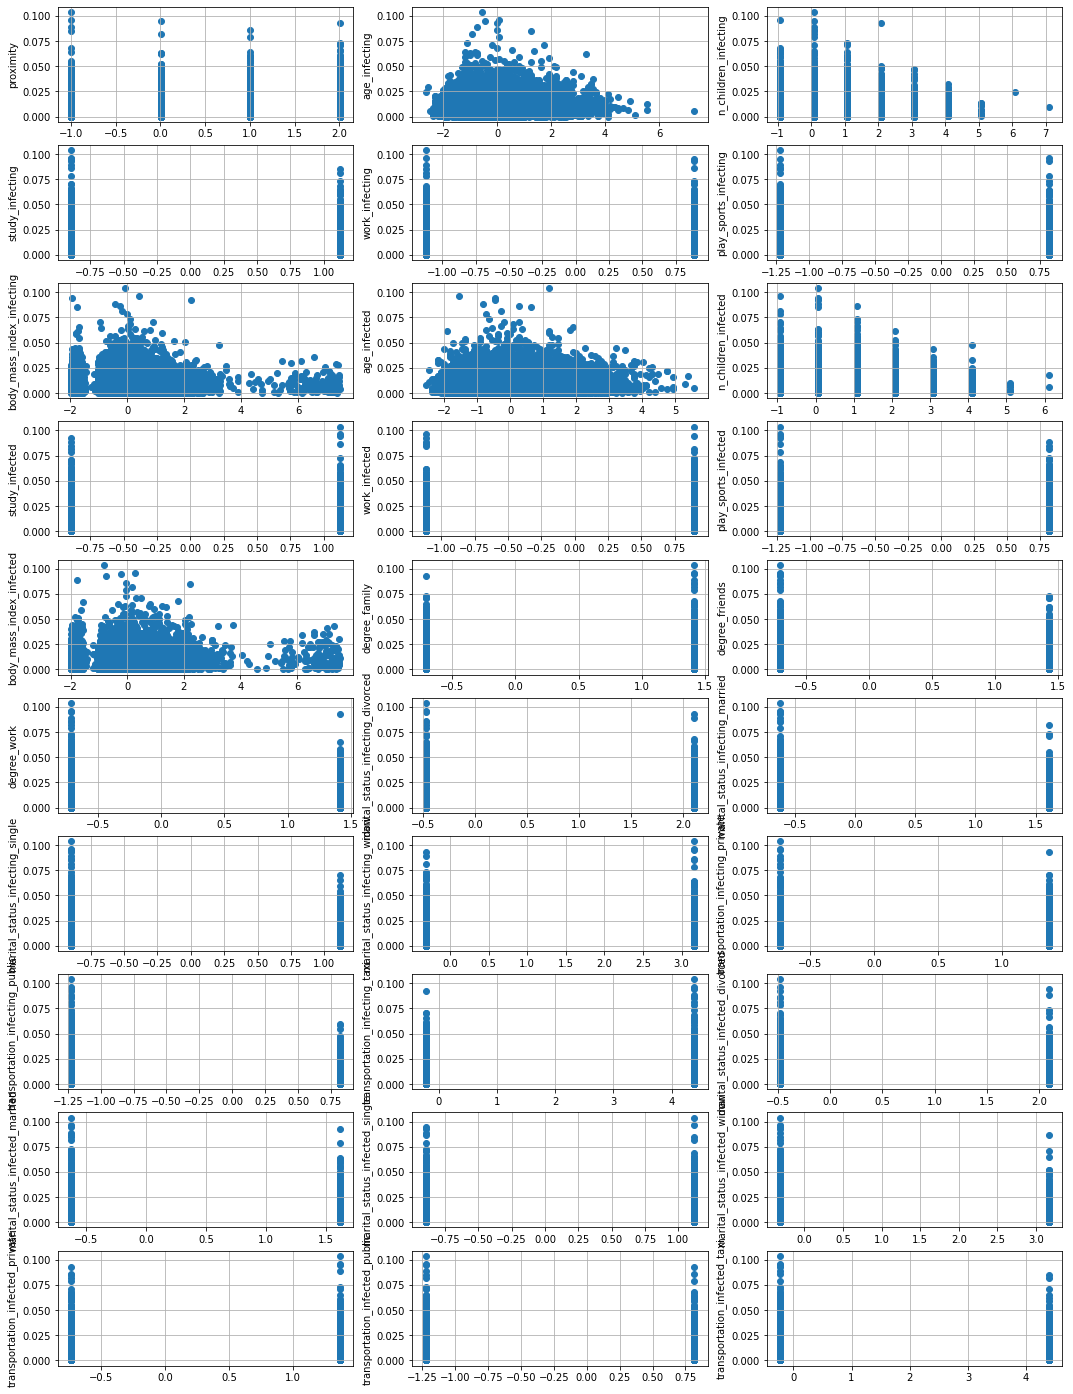

In [42]:
# Errors by feature
y_hat = predict(x_train_norm_subsample, results['model'])
mse = mean_absolute_error(y_train_subsample.reshape(1, -1), y_hat.reshape(1, -1), multioutput="raw_values")

i, j = 0, 0
_, ax = plt.subplots(nrows=10, ncols=3, figsize=(18, 25))
for k in range(x_train_norm_subsample.shape[1]):
    ax[i, j].scatter(x_train_norm_subsample[:, k], mse)
    ax[i, j].set_ylabel(x_train.columns[k])
    ax[i, j].grid(True)
    i = i + 1 if j == 2 else i
    j = j + 1 if j != 2 else 0
plt.show()

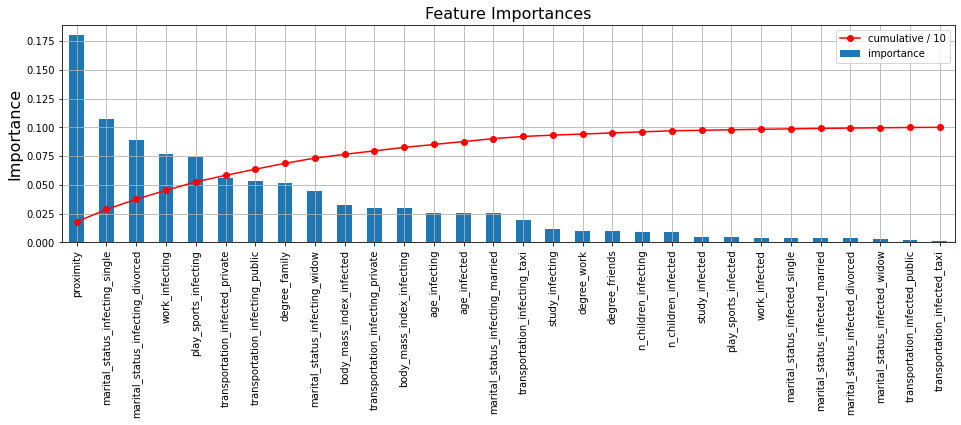

In [43]:
# Feature importance
importances = pd.Series(results['model'].feature_importances_, index=x_train.columns)
importances = importances.sort_values(ascending=False)
importances = importances / importances.apply(abs).sum()
cumulative_sum = importances.cumsum() / 10

plt.subplots(figsize=(16, 4))
importances.plot(kind='bar', label='importance')
plt.plot(range(len(importances)), cumulative_sum, color='r', label='cumulative / 10', marker='o')
plt.title('Feature Importances', size=16)
plt.ylabel('Importance', size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

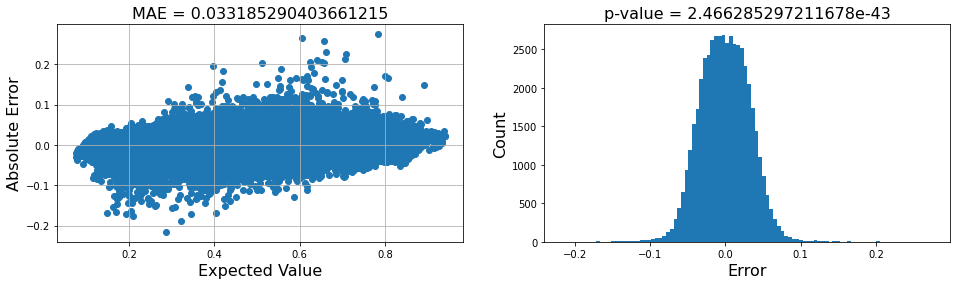

In [44]:
# Test
y_hat = predict(x_test_norm, results['model'])
evaluate(y_test, y_hat)

In [45]:
# Save submission predictions
y_submission = predict(x_submission_norm, results['model'])
submission = dataframe[['infected']].iloc[dataframe_submission.index]
submission['transmission_rate'] = y_submission
submission.to_csv('submission/submission.csv', sep=';', decimal='.', index=False, header=False)

**Observations:**
- with 23,000 (20%) samples our training took 40 minutes
- we still have a gap between training and validation errors (more samples would probably improve the results)
- the model was able to capture the features relationship
- the errors are fairly gaussian distributed
- features importances will be useful for taking actions
- with 9 out of 31 features we can reach a 75% of importance
- the infecting person looks to be more important than the infected one
- proximity, being single and divorced are the most important features

## 5 Taking Actions

Once we have a model that estimates transmission rate, we can predict the missing rates and simulate some actions to reduce the virus spread velocity in our whole population.

### 5.1 Feature's Impact

Let's update our dataset with the missing transmission rates and understand how features impact on the transmission.

In [46]:
# Update transmission rates
connections_complete = dataframe_numerical.copy()
connections_complete.loc[dataframe_submission.index, 'transmission_rate'] = y_submission
connections_complete['infecting'] = dataframe['infecting']
connections_complete['infected'] = dataframe['infected']
print(f'number of missing values: {connections_complete.isna().sum().sum()}')

number of missing values: 0


In [47]:
# Add reverse connections
connections_reverse = connections_complete.copy()

MAP = {
    'age_infecting': 'age_infected',
    'n_children_infecting': 'n_children_infected',
    'study_infecting': 'study_infected',
    'work_infecting': 'work_infected',
    'play_sports_infecting': 'play_sports_infected',
    'body_mass_index_infecting': 'body_mass_index_infected',
    'marital_status_infecting_divorced': 'marital_status_infected_divorced',
    'marital_status_infecting_married': 'marital_status_infected_married',
    'marital_status_infecting_single': 'marital_status_infected_single',
    'marital_status_infecting_widow': 'marital_status_infected_widow',
    'transportation_infecting_private': 'transportation_infected_private',
    'transportation_infecting_public': 'transportation_infected_public',
    'transportation_infecting_taxi': 'transportation_infected_taxi',
    'infecting': 'infected'
}
for feature_1, feature_2 in MAP.items():
    connections_reverse[feature_1] = connections_complete[feature_2]
    connections_reverse[feature_2] = connections_complete[feature_1]

infecting = connections_reverse['infecting']
infected = connections_reverse['infected']
connections_reverse = connections_reverse.drop(
    ['transmission_rate', 'infecting', 'infected'],
    axis=1
)

connections_reverse_norm = scaler.transform(connections_reverse)
y_reverse = predict(connections_reverse_norm, results['model'])

connections_reverse['transmission_rate'] = y_reverse
connections_reverse['infecting'] = infecting
connections_reverse['infected'] = infected

connections_updated = pd.concat([connections_complete, connections_reverse])
connections_updated = connections_updated.drop_duplicates(subset=['infecting', 'infected'])
connections_updated = connections_updated.reset_index(drop=True)

connections_updated

,proximity,transmission_rate,age_infecting,n_children_infecting,study_infecting,work_infecting,play_sports_infecting,body_mass_index_infecting,age_infected,n_children_infected,...,transportation_infecting_taxi,marital_status_infected_divorced,marital_status_infected_married,marital_status_infected_single,marital_status_infected_widow,transportation_infected_private,transportation_infected_public,transportation_infected_taxi,infecting,infected
0,2,0.589462,44.0,1.0,1.0,0.0,1.0,2.220096e+14,24.0,0.0,...,0,0,1,0,0,0,1,0,1,2
1,0,0.708465,44.0,1.0,1.0,0.0,1.0,2.220096e+14,35.0,1.0,...,0,0,0,1,0,1,0,0,1,3
2,1,0.635600,24.0,0.0,0.0,0.0,1.0,2.537872e+14,50.0,1.0,...,0,0,1,0,0,0,1,0,2,4
3,0,0.638842,24.0,0.0,0.0,0.0,1.0,2.537872e+14,30.0,2.0,...,0,0,0,1,0,0,1,0,2,5
4,3,0.350261,35.0,1.0,0.0,0.0,1.0,1.995239e+14,20.0,1.0,...,0,0,0,1,0,0,1,0,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999993,0,0.534565,34.0,1.0,0.0,1.0,1.0,1.755677e+13,23.0,0.0,...,0,0,1,0,0,0,1,0,999996,499998
1999994,0,0.559008,40.0,1.0,0.0,1.0,1.0,2.484840e+14,23.0,0.0,...,0,0,1,0,0,0,1,0,999997,499998
1999995,1,0.679451,30.0,1.0,0.0,0.0,1.0,2.089921e+14,26.0,3.0,...,0,0,1,0,0,0,0,1,999998,499999
1999996,0,0.329270,33.0,0.0,1.0,1.0,1.0,1.697957e+14,26.0,3.0,...,0,0,1,0,0,0,0,1,999999,499999


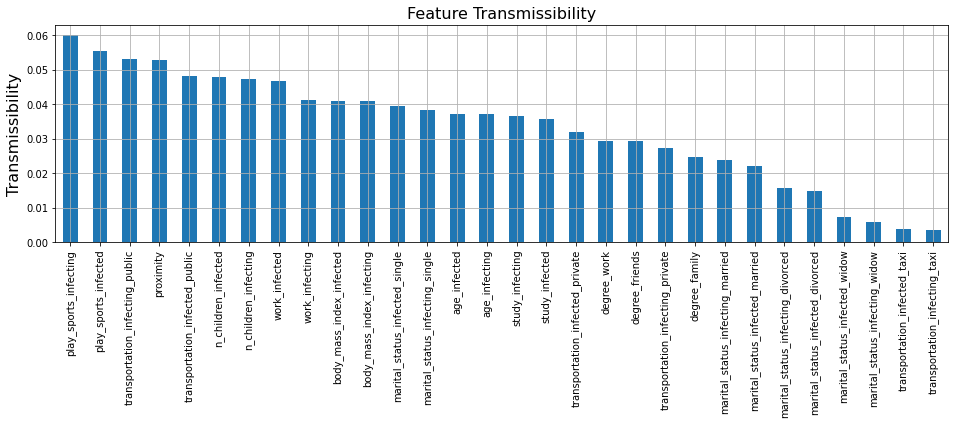

In [48]:
# Compute transmissibility

# FORMULA: transmissibility = mean transmission rate * connections with the feature

transmissibility = importances.copy()
for feature in transmissibility.index:
    feature_mean = connections_updated[feature].mean()
    connections_with_feature = connections_updated[connections_updated[feature] >= feature_mean]
    transmission_rate_mean = connections_with_feature['transmission_rate'].mean()
    n_connections_with_feature = len(connections_with_feature)
    transmissibility[feature] = transmission_rate_mean * n_connections_with_feature

plt.figure(figsize=(16, 4))
transmissibility = transmissibility.sort_values(ascending=False)
transmissibility = transmissibility / transmissibility.sum()
transmissibility.plot(kind='bar')
plt.title('Feature Transmissibility', size=16)
plt.ylabel('Transmissibility', size=16)
plt.grid()
plt.show()

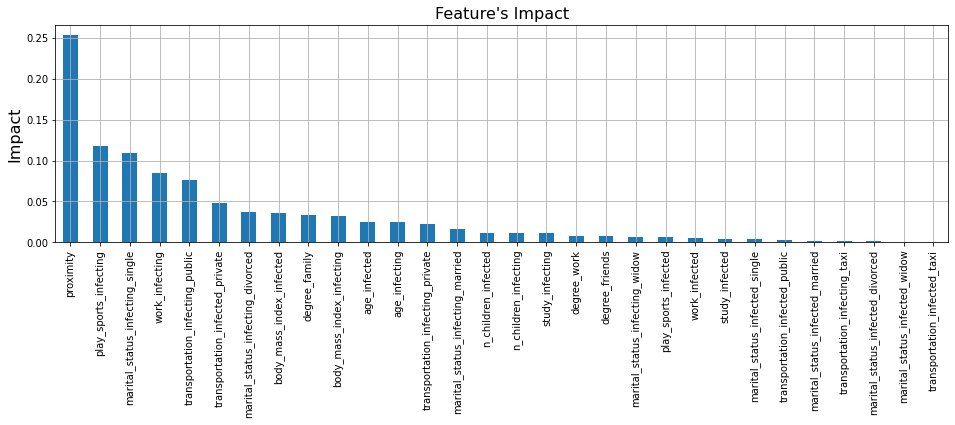

In [49]:
# Compute impact
feature_impact = importances * transmissibility
feature_impact = feature_impact.sort_values(ascending=False)
feature_impact = feature_impact / feature_impact.sum()

plt.figure(figsize=(16, 4))
feature_impact.plot(kind='bar')
plt.title("Feature's Impact", size=16)
plt.ylabel('Impact', size=16)
plt.grid()
plt.show()

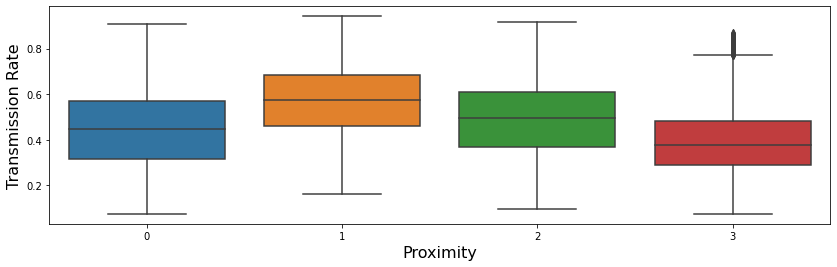

In [50]:
# How proximity affects the transmission rate?
plt.figure(figsize=(14, 4))
sns.boxplot(x='proximity', y='transmission_rate', data=connections_updated)
plt.xlabel('Proximity', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

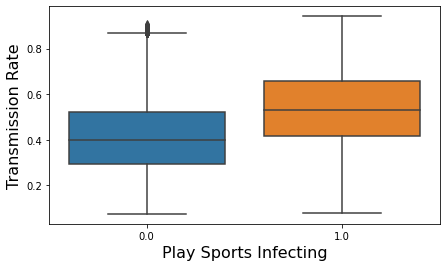

In [51]:
# How sports affect the transmission rate?
plt.figure(figsize=(7, 4))
sns.boxplot(x='play_sports_infecting', y='transmission_rate', data=connections_updated)
plt.xlabel('Play Sports Infecting', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

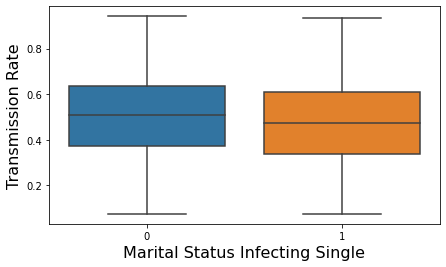

In [52]:
# How being single affects the transmission rate?
plt.figure(figsize=(7, 4))
sns.boxplot(x='marital_status_infecting_single', y='transmission_rate', data=connections_updated)
plt.xlabel('Marital Status Infecting Single', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

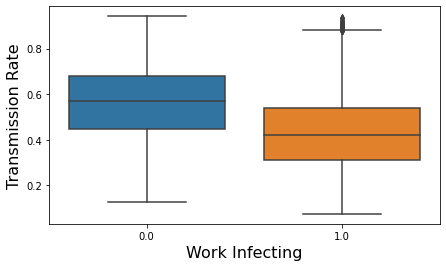

In [53]:
# How work affects the transmission rate?
plt.figure(figsize=(7, 4))
sns.boxplot(x='work_infecting', y='transmission_rate', data=connections_updated)
plt.xlabel('Work Infecting', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

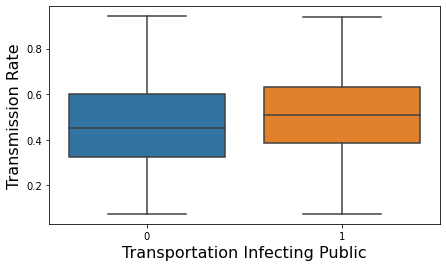

In [54]:
# How public transportation affects the transmission rate?
plt.figure(figsize=(7, 4))
sns.boxplot(x='transportation_infecting_public', y='transmission_rate', data=connections_updated)
plt.xlabel('Transportation Infecting Public', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

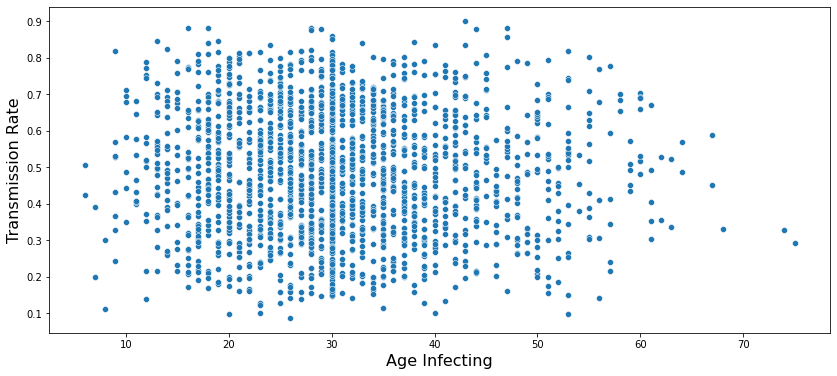

In [55]:
# How age affects the transmission rate?
plt.figure(figsize=(14, 6))
sns.scatterplot(x='age_infected', y='transmission_rate', data=connections_updated.iloc[0:2000])
plt.xlabel('Age Infecting', size=16)
plt.ylabel('Transmission Rate', size=16)
plt.show()

### 5.2 Running Simulations

We can simulate actions and understand what would be the epidemic contamination curve to see its impact.

In [56]:
# Contamination function

# FORMULA: N = SI (SI epidemic model)

RUNS = 1
N_FIRST_INFECTED = 100
STEPS = 30
def compute_contamination_curve(connections):

    connections_size = len(connections)
    max_ids = len(population)
    infecting = connections[['infecting']]
    infected = connections[['infected']]

    # Runs
    contamination_curve_list = []
    for _ in range(RUNS):

        # Initiate with no infections
        infecting['status'] = 0
        infected['status'] = 0

        # First infected
        first_infected = infecting['infecting'].values
        np.random.shuffle(first_infected)
        first_infected = first_infected[:N_FIRST_INFECTED]
        infecting['status'] = np.where(infecting['infecting'].isin(first_infected), 1, 0)
        infected['status'] = np.where(infected['infected'].isin(first_infected), 1, 0)
        
        # Steps
        contamination_curve = [N_FIRST_INFECTED/max_ids]
        for _ in range(STEPS):

            # Compute new infected
            probabilities = np.random.uniform(size=(connections_size))
            condition = (
                (connections['transmission_rate'] >= probabilities) &
                (infecting['status'] == 1) &
                (infected['status'] == 0)
            )
            new_infected = infected['infected'][condition]

            # Update infected
            infecting['status'] = np.where(infecting['infecting'].isin(new_infected), 1, infecting['status'])
            infected['status'] = np.where(infected['infected'].isin(new_infected), 1, infected['status'])
            
            # Append contamination
            current_ids = len(np.unique(
                infecting['infecting'][infecting['status'] == 1].tolist() +
                infected['infected'][infected['status'] == 1].tolist()
            ))
            contamination_curve.append(current_ids / max_ids)

        contamination_curve_list.append(contamination_curve)

    contamination_curve_list = np.array(contamination_curve_list)
    contamination_curve_mean = contamination_curve_list.mean(axis=0)
    contamination_curve_std = contamination_curve_list.std(axis=0)

    return contamination_curve_mean, contamination_curve_std

In [57]:
# Maximum spread velocity

# FORMULA: max(t0 - t7)

def compute_max_spread_velocity(contamination_curve):
    dataframe = pd.DataFrame({'t0': contamination_curve})
    dataframe['t-7'] = dataframe.shift(7)
    dataframe['spread'] = dataframe['t0'] - dataframe['t-7']
    max_spread = dataframe['spread'].max()
    index = dataframe[dataframe['spread'] == max_spread].index[0]
    return max_spread, index

In [58]:
# Plot function
def plot_contamination_curve(dict_of_curves):
    plt.figure(figsize=(14, 5))
    for label, item in dict_of_curves.items():
        mean = item['mean']
        std = item['std']
        size = range(len(mean))
        plt.fill_between(size, mean - std, mean + std, alpha=0.1)
        plt.plot(size, mean, label=f'{label}')
    plt.title('Contamination Curves', size=16)
    plt.ylabel('Infected Population (%)', size=16)
    plt.xlabel('Time', size=16)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [59]:
# Initiate dictionary of plots
dict_of_curves = {}

In [60]:
# Baseline curve
baseline_mean, baseline_std = compute_contamination_curve(connections_updated)
baseline_spread_velocity, baseline_spread_index = compute_max_spread_velocity(baseline_mean)
dict_of_curves['baseline'] = {
    'mean': baseline_mean,
    'std': baseline_std,
    'velocity': baseline_spread_velocity,
    'index': baseline_spread_index
}

In [61]:
# What if we could reduce the transmission rate by 70% using mask?
connections_mask = connections_updated.copy()
connections_mask['transmission_rate'] = np.where(
    np.random.uniform(size=len(connections_updated)) > 0.2,  # How effective I believe we can be
    connections_mask['transmission_rate'] * 0.3,
    connections_mask['transmission_rate']
)
mask_mean, mask_std = compute_contamination_curve(connections_mask)
mask_spread_velocity, mask_spread_index = compute_max_spread_velocity(mask_mean)
dict_of_curves['mask'] = {
    'mean': mask_mean,
    'std': mask_std,
    'velocity': mask_spread_velocity,
    'index': mask_spread_index
}

In [62]:
# What if we limited our proximity?
connections_proximity = connections_updated[
    (connections_updated['proximity'] >= 3) |
    (np.random.uniform(size=len(connections_updated)) > 0.2)  # How effective I believe we can be
]
proximity_mean, proximity_std = compute_contamination_curve(connections_proximity)
proximity_spread_velocity, proximity_spread_index = compute_max_spread_velocity(proximity_mean)
dict_of_curves['proximity'] = {
    'mean': proximity_mean,
    'std': proximity_std,
    'velocity': proximity_spread_velocity,
    'index': proximity_spread_index
}

In [63]:
# What if we make everyone to stop doing sports?
connections_sports = connections_updated.copy()

# select IDs
ids = connections_sports['infecting'].unique()
n_ids = int(len(ids) * 0.8) # How effective I believe we can be
np.random.shuffle(ids)
selected_ids = ids[:n_ids]

# replace IDs
connections_sports['play_sports_infecting'] = np.where(
    connections_sports['infecting'].isin(selected_ids), 0, connections_sports['play_sports_infecting']
)
connections_sports['play_sports_infected'] = np.where(
    connections_sports['infected'].isin(selected_ids), 0, connections_sports['play_sports_infected']
)

# recompute transmission rate
connections_sports_norm = scaler.transform(connections_sports.drop(['infecting', 'infected', 'transmission_rate'], axis=1))
y_sports = predict(connections_sports_norm, results['model'])
connections_sports['transmission_rate'] = y_sports

# compute contamination curve
sports_mean, sports_std = compute_contamination_curve(connections_sports)
sports_spread_velocity, sports_spread_index = compute_max_spread_velocity(sports_mean)
dict_of_curves['sports'] = {
    'mean': sports_mean,
    'std': sports_std,
    'velocity': sports_spread_velocity,
    'index': sports_spread_index
}

In [64]:
# What if we make everyone to use private transportation?
connections_private = connections_updated.copy()

# select IDs
ids = connections_private['infecting'].unique()
n_ids = int(len(ids) * 0.8) # How effective I believe we can be
np.random.shuffle(ids)
selected_ids = ids[:n_ids]

# replace IDs
connections_private['transportation_infecting_public'] = np.where(
    connections_private['infecting'].isin(selected_ids), 0, connections_private['transportation_infecting_public']
)
connections_private['transportation_infecting_taxi'] = np.where(
    connections_private['infecting'].isin(selected_ids), 1, connections_private['transportation_infecting_taxi']
)
connections_private['transportation_infecting_private'] = np.where(
    connections_private['infecting'].isin(selected_ids), 0, connections_private['transportation_infecting_private']
)
connections_private['transportation_infected_public'] = np.where(
    connections_private['infected'].isin(selected_ids), 0, connections_private['transportation_infected_public']
)
connections_private['transportation_infected_taxi'] = np.where(
    connections_private['infected'].isin(selected_ids), 1, connections_private['transportation_infected_taxi']
)
connections_private['transportation_infected_private'] = np.where(
    connections_private['infected'].isin(selected_ids), 0, connections_private['transportation_infected_private']
)

# recompute transmission rate
connections_private_norm = scaler.transform(connections_private.drop(['infecting', 'infected', 'transmission_rate'], axis=1))
y_private = predict(connections_private_norm, results['model'])
connections_private['transmission_rate'] = y_private

# compute contamination curve
private_mean, private_std = compute_contamination_curve(connections_private)
private_spread_velocity, private_spread_index = compute_max_spread_velocity(private_mean)
dict_of_curves['private'] = {
    'mean': private_mean,
    'std': private_std,
    'velocity': private_spread_velocity,
    'index': private_spread_index
}

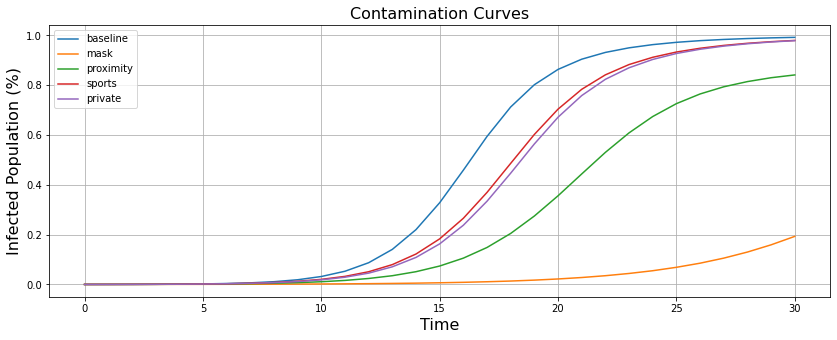

In [65]:
# Plot contamination curve
plot_contamination_curve(dict_of_curves)

**Observations:**
- this is an SI epidemic, it means that there's no cure, so no one recovers
- the problem doesn't state if the virus can kill, so it wasn't considered
- the missing values from the population connections were completed
- the connections were also reversed because the same way person A can transmit the virus to B, B can transmit to A with a different transmission rate
- the transmissibility rate of the features was calculated - it's a way to combine transmission rate and the number of connections impacted from each feature
- feature's impact was computed - it's a combination of feature importane and transmissibility
- actions were took based on the feature's impact

## 6 Conclusions

In this project we first took a look at the data to understand what we are dealing with and what kind of preprocess would have to be done.  
With the correct dataset, we created a model to estimate the virus transmission rate between two people.  
It was now possible to complete the missing transmission rate for the whole population.  
Not only that, we could also interpret the model to understand the most important features that impact in the transmission rate.  
Finally, experiments using the population connections were ran to evaluate the contamination curve and actions were simulated to understand its impacts.

**Suggested actions:** (based on feature' importance, transmission rate and the number of connections)
- limit proximity: it's a lockdown, where only people who live together can connect with each other
- use mask: is a simple way to reduce transmission rate without changing any characteristic or connection
- stop playing sports: is an effort to change people characteristic to not play sports in orther to reduce transmission rate
- stop using public transportation: without public transportation, people have to take your own transportation to reduce transmisison rate

**Future work:**
- remove multicollinearity
- remove outliers
- perform feature selection
- optimize the model's hyperparameters
- use clustering analysis to find groups of similar people with more chance of infecting someone or be infected
- collect more features like the time of infection and people's address
- improve simulation
- try different actions
- combine actions